In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import os
import numpy as np
import pandas as pd
from utils import LabelEncoder, iterative_train_test_split, save_json
from torch.utils.data import DataLoader
import random
import itertools as itl
import pathlib
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
from PlotUtils import * 

# Set randomness seeds for reproducibility
seed = 42
# random.seed(seed)
np.random.seed(seed)


In [3]:
# -- Encoding Labels --
# Load image and labels names
Data = pd.read_csv('Data/train.csv')
images = Data['image']
labels = Data['labels']
OL = [label.split(' ') for label in labels]

X = np.array(images) # Images name
y = np.array(OL, dtype=object) # Labels

## Mapping labels (words) to numeric codification
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

## Encoding all labels in the dataset
y = label_encoder.encode(y)
print (y.shape)

(18632, 6)


In [4]:
# -- Stratified data partitioning --
train_size = 0.7
val_size = 0.15
test_size = 0.15 
# Execute partitioning: Training - Validation - Testing
X_train, X_, y_train, y_ = iterative_train_test_split(
    images.to_numpy(), y, train_size=train_size)
X_val, X_test, y_val, y_test = iterative_train_test_split(
    X_, y_, train_size=round(test_size/(1-train_size),2))

# Looking the splits sizes
print(f"Train:       {len(X_train)} ({len(X_train)/len(images):.2f})\n"
      f"Validation:  {len(X_val)} ({len(X_val)/len(images):.2f})\n"
      f"Test:        {len(X_test)} ({len(X_test)/len(images):.2f})")

## Perform the counts on each class before and after partitioning
countsP = {}
countsP["total_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y, order=1) for combination in row)
countsP["train_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_train, order=1) for combination in row)
countsP["val_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_val, order=1) for combination in row)
countsP["test_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_test, order=1) for combination in row)

# Visualización despues del ajuste de conteos entre las particioneso
CountsDF = pd.DataFrame({
           "total": countsP["total_counts"],
            "train": countsP["train_counts"],
            "val": countsP["val_counts"],
            "test": countsP["test_counts"]
        }).T.fillna(0)

for k in countsP["val_counts"].keys():
    countsP["val_counts"][k] = int(countsP["val_counts"][k] * \
        (train_size/val_size))
for k in countsP["test_counts"].keys():
    countsP["test_counts"][k] = int(countsP["test_counts"][k] * \
        (train_size/test_size))


# Calculate the standard deviation from the 'ideal' partition.
print('Standar deviation from the ideal partition: ',np.mean(np.std(pd.DataFrame(countsP).T.iloc[1:].to_numpy(), axis=0)))

print('\nCounts per category in each partition:')
CountsDF

Train:       13044 (0.70)
Validation:  2774 (0.15)
Test:        2814 (0.15)
Standar deviation from the ideal partition:  1.5029634465624262

Counts per category in each partition:


,"(2,)","(0,)","(1,)","(5,)","(4,)","(3,)"
total,4624,2151,4352,5712,2077,1271
train,3237,1506,3046,3998,1454,890
val,694,322,653,857,312,191
test,693,323,653,857,311,190


In [26]:
label_encoder.index_to_class

{0: 'complex',
 1: 'frog_eye_leaf_spot',
 2: 'healthy',
 3: 'powdery_mildew',
 4: 'rust',
 5: 'scab'}

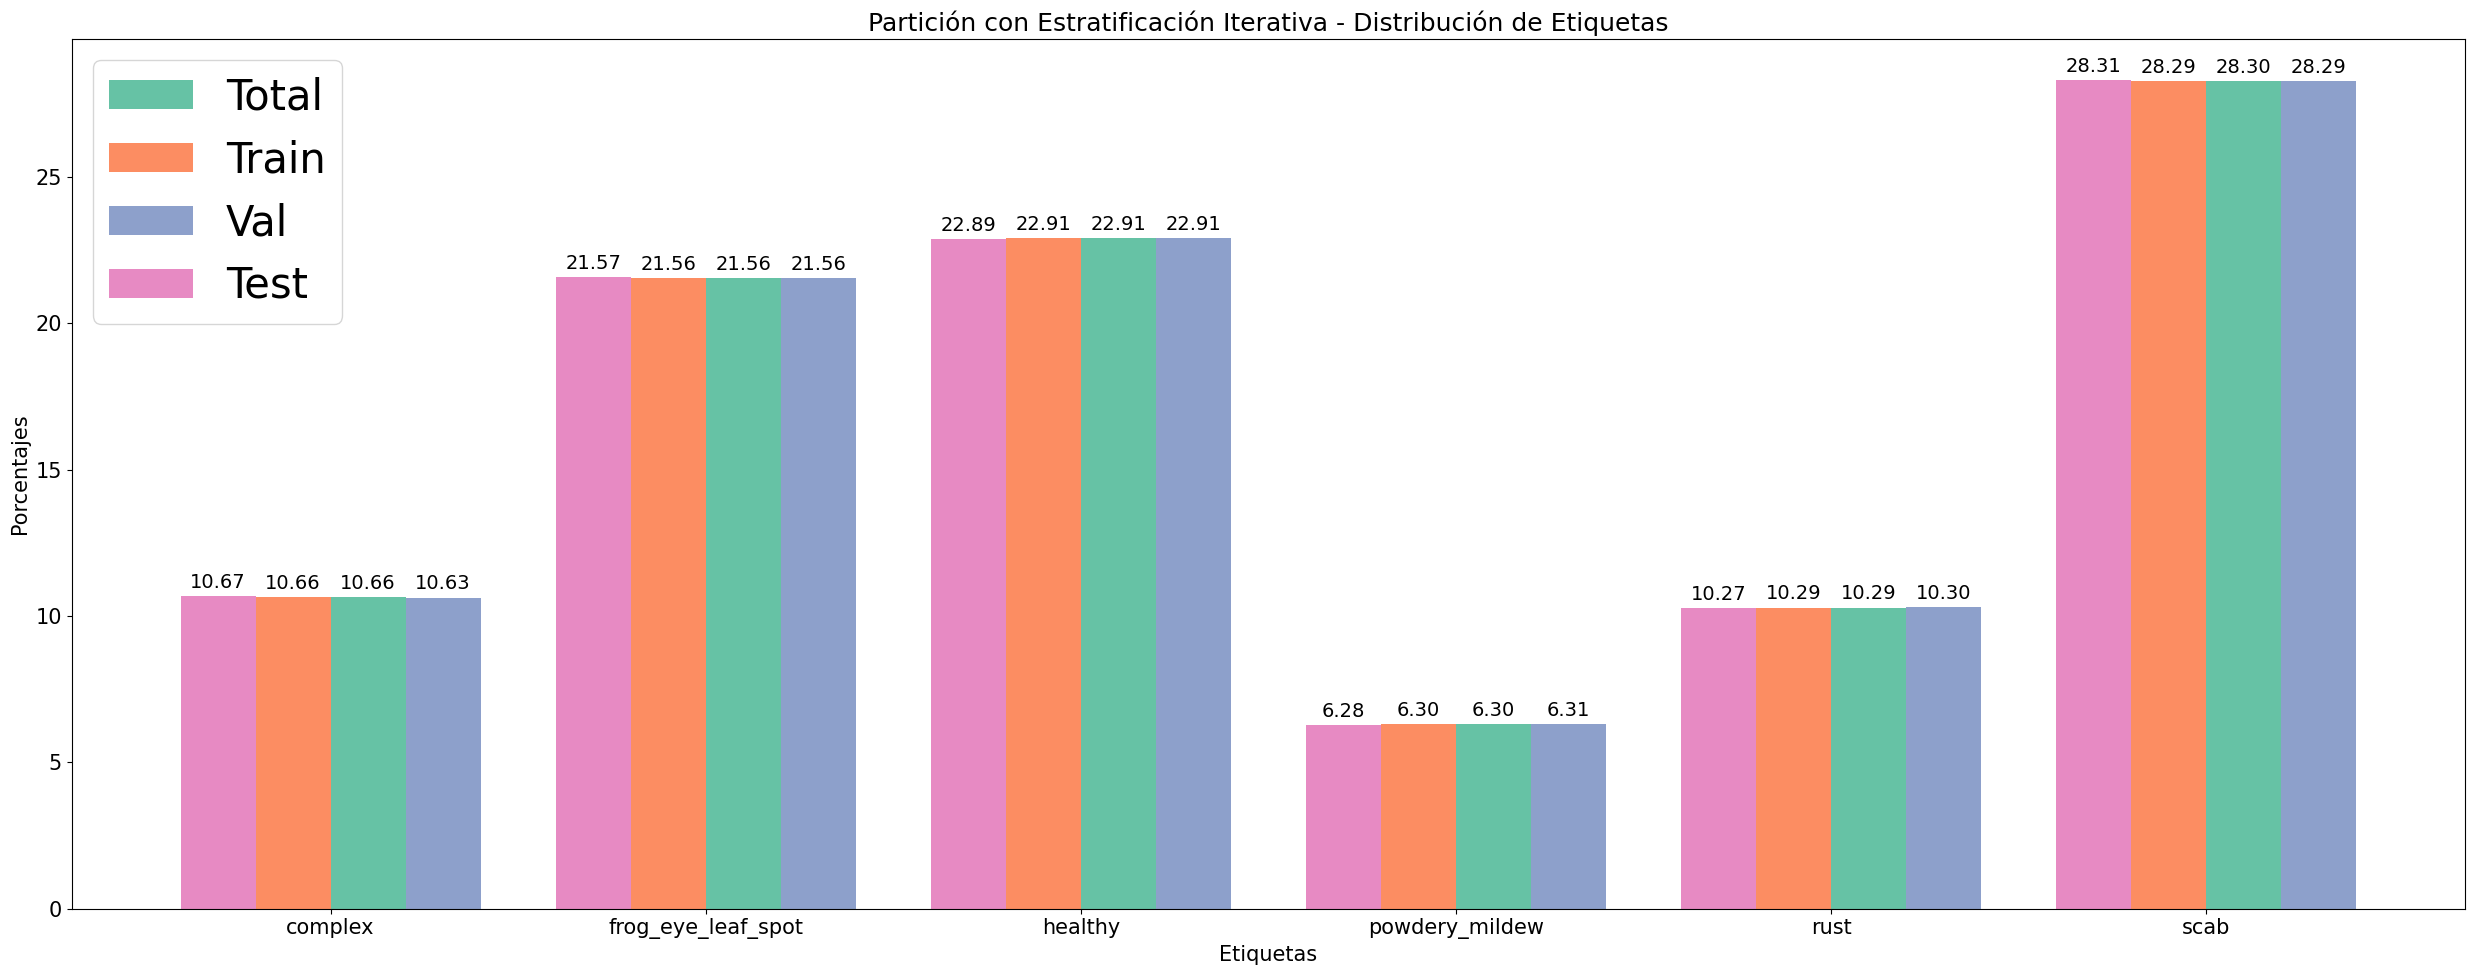

In [13]:
df =CountsDF.T.sort_index().T
data = {
   "Total": (list(df.loc['total'])/sum(list(df.loc['total'])))*100,
    "Train": (list(df.loc['train'])/sum(list(df.loc['train'])))*100,
    "Val": (list(df.loc['val'])/sum(list(df.loc['val'])))*100,
    "Test": (list(df.loc['test'])/sum(list(df.loc['test'])))*100
}
xticks = label_encoder.classes
title = 'Partición con Estratificación Iterativa - Distribución de Etiquetas'
axlb = ['Etiquetas', 'Porcentajes'] 
groupedBarPlot(data, xticks, title, colors=plt.cm.Set2.colors, axislabels = axlb, width = 0.2)

In [21]:
# Save the data partitions in  a json file
mappingR = {v:k for k,v in label_encoder.class_to_index.items()}
split1 = {
 "Train": {ins: lab for ins,lab in zip(X_train.tolist(),[[mappingR[i] for i,item in enumerate(lab) if item == 1] for lab in y_train])},
    "Val": {ins: lab for ins,lab in zip(X_val.tolist(),[[mappingR[i] for i,item in enumerate(lab) if item == 1] for lab in y_val])},
    "Test": {ins: lab for ins,lab in zip(X_test.tolist(),[[mappingR[i] for i,item in enumerate(lab) if item == 1] for lab in y_test])}
}
save_json(split1, pathlib.Path('Data/Splits/split1.json'))